**Google-colabs:** https://colab.research.google.com/drive/19TUJHL5S6dVNajnW7zqVVChRxLz7vfhv?usp=sharing

In [50]:
import os
import glob
import shutil
import random
import time

import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import nn, optim
from PIL import Image
from torchvision.transforms import Resize
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [2]:
class FetalPlaneDataset(Dataset):
    """Fetal Plane dataset."""

    def __init__(self,
                 root_dir,
                 csv_file,
                 plane=None,
                 brain_plane=None,
                 us_machine=None,
                 operator_number=None,
                 transform=None,
                 split_type=None,
                 split="train",
                 train_size=100,
                 downsampling_factor=2,
                 return_labels=False
                 ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            plane: 'Fetal brain'; 'Fetal thorax'; 'Maternal cervix'; 'Fetal femur'; 'Fetal thorax'; 'Other'
            brain_plane: 'Trans-ventricular'; 'Trans-thalamic'; 'Trans-cerebellum'
            us_machine: 'Voluson E6';'Voluson S10'
            operator_number: 'Op. 1'; 'Op. 2'; 'Op. 3';'Other'
            split_type (string, optional): Method to split dataset, supports "manual", and "csv"
            split (string): Which partition to return, supports "train", and "valid"
            train_size:  Limit dataset size to 100 images (for training)
            return_labels: Return the plane of the image

        return image, downsampled_image
        """
        self.transform = transform
        self.downsampling_factor = downsampling_factor
        self.root_dir = root_dir
        self.csv_file = pd.read_csv(csv_file, sep=';')
        self.return_labels = return_labels
        self.plane = plane

        if self.plane:
          self.csv_file = self.csv_file[self.csv_file['Plane'] == self.plane]
          if self.plane == 'Fetal brain':
            self.csv_file = self.csv_file[self.csv_file['Brain_plane'] != 'Other']
        if brain_plane:
            self.csv_file = self.csv_file[self.csv_file['Brain_plane'] == brain_plane]
        if us_machine is not None:
            self.csv_file = self.csv_file[self.csv_file['US_Machine'] == us_machine]
        if operator_number is not None:
            self.csv_file = self.csv_file[self.csv_file['Operator'] == operator_number]

        self.train_size = train_size

        # Split data manually
        if split_type == "manual":
            if split == "train":
                self.csv_file = self.csv_file[:self.train_size]
            elif split == "valid":
                self.csv_file = self.csv_file[self.train_size:]
        # Split data according to CSV
        elif split_type == "csv":
            if split == "train":
                self.csv_file = self.csv_file[self.csv_file['Train '] == 1]
            elif split == "valid":
                self.csv_file = self.csv_file[self.csv_file['Train '] == 0]

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # Load the image from file

        # print(f'idx: {idx} \n')
        # print(f'self.csv_file.iloc[idx, 0]: {self.csv_file.iloc[idx, 0]} \n')

        img_name = os.path.join(self.root_dir,
                                self.csv_file.iloc[idx, 0] + '.png')
        # print(img_name)
        image = Image.open(img_name)  # <class 'numpy.ndarray'>

        # print(type(image))
        # print(image.dtype)

        # Preprocess and augment the image
        if self.transform:
            image = self.transform(image)

        ## Downsample image for SRGAN
        size = image.size()
        tr_resize = Resize((int(size[1] / self.downsampling_factor), int(size[2] / self.downsampling_factor)))
        ds_image = tr_resize(image)
        # .cpu().numpy()#TypeError: Cannot interpret 'torch.float32' as a data type

        # Return labels for classification task
        if self.return_labels:
            if self.plane == 'Fetal brain':
              im_plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 3]), axis=0)
              if im_plane == 'Trans-thalamic':
                im_plane = 0
              elif im_plane == 'Trans-ventricular':
                im_plane = 1
              elif im_plane == 'Trans-cerebellum':
                im_plane = 2
            else:
              im_plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 2]), axis=0)
              if im_plane == 'Other':
                  im_plane = 0
              elif im_plane == 'Fetal brain':
                  im_plane = 1
              elif im_plane == 'Fetal abdomen':
                  im_plane = 2
              elif im_plane == 'Fetal femur':
                  im_plane = 3
              elif im_plane == 'Fetal thorax':
                  im_plane = 4
              elif im_plane == 'Maternal cervix':
                  im_plane = 4
            return image, im_plane
        else:
            return image, ds_image


class AfricanFetalPlaneDataset(Dataset):
    """African Fetal Plane dataset."""

    def __init__(self,
                 root_dir,
                 csv_file,
                 plane=None,
                 country=None,
                 transform=None,
                 split_type=None,
                 split="Train",
                 train_size=100,
                 downsampling_factor=2,
                 return_labels=False
                 ):
        """
        Args:
            root_dir (string): Directory with all the images.
            csv_file (string): Path to the csv file with annotations.
            plane: 'Fetal brain', 'Fetal abdomen','Fetal femur', 'Fetal thorax'
            country: 'Algeria', 'Egypt', 'Malawi', 'Uganda', 'Ghana'
            transform (callable, optional): Optional transform to be applied on a sample.
            split_type (string, optional): Method to split dataset, supports "manual", and "csv"
            split (string): Which partition to return, supports "train", and "valid"
            train_size:  Limit dataset size to 100 images (for training)
            downsampling_factor: downsampling image
            return_labels: Return the plane and country of the image

        return image, downsampled_image
        """
        self.transform = transform
        self.downsampling_factor = downsampling_factor
        self.root_dir = root_dir
        self.plane = plane
        self.country = country
        self.csv_file = pd.read_csv(csv_file, sep=',')
        self.return_labels = return_labels

        if self.plane is not None:
            self.csv_file = self.csv_file[self.csv_file['Plane'] == self.plane]
        if self.country is not None:
            self.csv_file = self.csv_file[self.csv_file['Center'] == self.country]

        # Split data manually
        if split_type == "manual":
            if split == "train":
                self.csv_file = self.csv_file[:train_size]
            elif split == "valid":
                self.csv_file = self.csv_file[train_size:]
        # Split data according to CSV
        elif split_type == "csv":
            if split == "train":
                self.csv_file = self.csv_file[self.csv_file['Train'] == 1]
            elif split == "valid":
                self.csv_file = self.csv_file[self.csv_file['Train'] == 0]

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        # Load the random image from file

        # print(f'idx: {idx} \n')
        # print(f'self.csv_file.iloc[idx, 4]: {self.csv_file.iloc[idx, 4]} \n')#Filename

        img_name = os.path.join(self.root_dir,
                                self.csv_file.iloc[idx, 4] + '.png') #Filename
        image = Image.open(img_name)  # <class 'numpy.ndarray'>

        # print(type(image))
        # print(image.dtype)

        if self.transform:
            image = self.transform(image)

        ## Downsample image for SRGAN
        size = image.size()
        tr_resize = Resize((int(size[1] / self.downsampling_factor), int(size[2] / self.downsampling_factor)))
        ds_image = tr_resize(image)

        # Return labels for classification task
        if self.return_labels:
            plane = np.expand_dims(np.asarray(self.csv_file.iloc[idx, 1]), axis=0)
            if plane == 'Fetal brain':
                plane = 0
            elif plane == 'Fetal abdomen':
                plane = 1
            elif plane == 'Fetal femur':
                plane = 2
            elif plane =='Fetal thorax':
                plane = 3
            return image, plane

        else:
            return image, ds_image

In [3]:
def save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, save_path):
  state = {
    'epoch': epoch,
    'best_epoch': best_epoch,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
  }
  torch.save(state, save_path)

def load_model(model_path, device, model=None, optimizer=None):
  if device == "cpu":
    state = torch.load(model_path, map_location=torch.device('cpu'))
  else:
    state = torch.load(model_path)

  epoch = state['epoch']
  best_epoch = state['best_epoch']
  train_losses = state['train_losses']
  val_losses = state['val_losses']

  if model:
    model.load_state_dict(state['state_dict'])
  if optimizer:
    optimizer.load_state_dict(state['optimizer'])

  return epoch, best_epoch, model, optimizer, train_losses, val_losses


def train_model(train_dataloader, 
                val_dataloader, 
                model, 
                optimizer, 
                num_epochs, 
                model_save_path, 
                checkpoint_save_path, 
                device, 
                load_checkpoint=False):
  start = time.time()
  train_losses = []
  val_losses = []
  best_loss = 100
  best_epoch = 0
  s_epoch = 0

  if load_checkpoint:
    s_epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(checkpoint_save_path, device, model, optimizer)
    best_loss = val_losses[best_epoch]

  #TODO add if to print or not model
  # print(model)
  for epoch in range(s_epoch, num_epochs):
    model.train()
    running_loss = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels).mean()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if i % 10 == 0:
        print(f"Epoch {epoch} iteration {i} training loss: {loss.item()}")

    train_epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)


    model.eval()
    with torch.no_grad():
      running_loss = 0
      for inputs, labels in val_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels).mean()
        running_loss += loss.item()
      val_epoch_loss = running_loss / len(val_dataloader)
      val_losses.append(val_epoch_loss)
      if epoch == 0:
        best_loss = val_epoch_loss
      elif val_epoch_loss < best_loss:
        best_loss = val_epoch_loss
        best_epoch = epoch
        save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, model_save_path)

      save_model(model, optimizer, epoch, best_epoch, train_losses, val_losses, checkpoint_save_path)
      print(f"Epoch {epoch} average training loss: {train_epoch_loss}, average validation loss: {val_epoch_loss}")
      end = time.time()
      print(f"Running time: {end - start}s")
  end = time.time()
  print(f"Execution time: {end - start}s")

In [4]:
def plot_training_curve(train_losses, val_losses, best_epoch=None, title=None):
  plt.plot(train_losses, label="Train")
  plt.plot(val_losses, label="Test")
  if title:
    plt.title(title)
  if best_epoch:
    plt.axvline(x=best_epoch, color='#9f9f9f', label=(f"Best Epoch: {best_epoch}"), ls="--", lw=1)
  plt.legend()
  plt.show()

def evaluate_model(y_true, y_pred, class_names):
  accuracy = accuracy_score(y_true, y_pred)
  p, r, f, s = precision_recall_fscore_support(y_true, y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {p}")
  print(f"Recall: {r}")
  print(f"F1: {f}")
  print(f"Support: {s}")

  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names)
  plt.show()



# African Dataset

In [47]:
# !unzip /content/drive/MyDrive/FETAL_PLANES_ZENODO.zip -d /content/drive/MyDrive/fetalplane_dataset
DATA_PATH="/home/mxochicale/datasets/african-fetal-us-2023/Zenodo_dataset"
# DATA_PATH="/content/drive/MyDrive/african_dataset/Images"



## Train Model

In [48]:

DATABASE_CSV=DATA_PATH+"/African_planes_database.csv"

image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_train_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                                 DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

(217, 233)


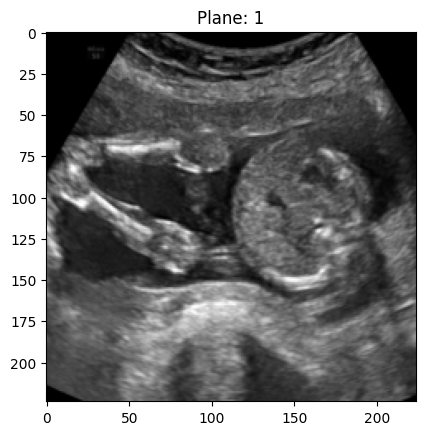

In [9]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()
    break

In [10]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# num_epochs = 100
num_epochs=3
model_save_path = DATA_PATH+'/models/afr_clf.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_ckpt.pt'

if not os.path.exists(DATA_PATH+"/models"):
    os.mkdir(DATA_PATH+"/models")


train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)



/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Execution time: 0.4833054542541504s


## Train with augmentation

In [15]:
image_size = 224
transform_operations=transforms.Compose([
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(15),
                        transforms.RandomResizedCrop([image_size, image_size], (0.8, 1.0)),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Normalize((0.5), (0.5)),
                        ])
val_transforms = transform_operations=transforms.Compose([
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])


african_train_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=val_transforms,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

(217, 233)


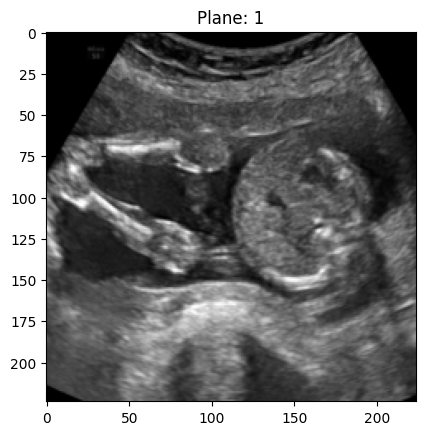

In [16]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()
    break

In [17]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
num_epochs = 3
# num_epochs = 100
# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_aug_clf.pt'
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_aug_ckpt.pt'

model_save_path = DATA_PATH+'/models/afr_aug_clf.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_aug_ckpt.pt'

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)


/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 2 iteration 0 training loss: 0.037670839577913284
Epoch 2 average training loss: 0.4787601312622428, average validation loss: 0.7080864913761615
Running time: 19.77887797355652s
Execution time: 19.778920888900757s


## Train with 80/20

In [19]:
# african_dataset_csv = pd.read_csv("/content/drive/MyDrive/african_dataset/African_planes_database.csv", delimiter=",")

DATABASE_CSV=DATA_PATH+"/African_planes_database.csv"
DATABASE_CSV_8020=DATA_PATH+"/African_planes_database_8020.csv"
african_dataset_csv = pd.read_csv(DATABASE_CSV, delimiter=",")


# Using filename to give each patient an ID to split on
filename = african_dataset_csv["Filename"]
patient_id = [f.split("_plane")[0] for f in filename]
african_dataset_csv["Patient_id"] = patient_id

# Get number of train and val
train_data = african_dataset_csv.loc[african_dataset_csv['Train']==1]
val_data = african_dataset_csv.loc[african_dataset_csv['Train']==0]
train_patient_num = train_data["Patient_id"].nunique()
val_patient_num = val_data["Patient_id"].nunique()
print(f"Number of patients in train {train_patient_num}, val {val_patient_num}")

# Get values for splitting
val_split = round((train_patient_num + val_patient_num) * 0.2)
train_split = round((train_patient_num + val_patient_num) * 0.8)
print(f"For 80/20 split, number of patients in train {train_split}, val {val_split}")
num_convert = train_split - train_patient_num
print(f"Number of validation images to convert {num_convert}")

# Convert val to train
val_patient = list(val_data["Patient_id"].unique())
random.shuffle(val_patient)
for patient in val_patient[:num_convert]:
  african_dataset_csv.loc[african_dataset_csv["Patient_id"] == patient, "Train"] = 1

# Check all working correctly
new_train_data = african_dataset_csv.loc[african_dataset_csv['Train']==1]
new_val_data = african_dataset_csv.loc[african_dataset_csv['Train']==0]
new_train_patient_num = new_train_data["Patient_id"].nunique()
new_val_patient_num = new_val_data["Patient_id"].nunique()
print(f"New number of patients in train {new_train_patient_num}, val {new_val_patient_num}")

# Drop ID column to keep original columns and save
african_dataset_csv.drop(["Patient_id"], axis=1)
african_dataset_csv.to_csv(DATABASE_CSV_8020, index=False,sep=",")

Number of patients in train 61, val 66
For 80/20 split, number of patients in train 102, val 25
Number of validation images to convert 41
New number of patients in train 102, val 25


In [20]:
new_train_data["Plane"].value_counts()

Plane
Fetal abdomen    100
Fetal femur      100
Fetal brain      100
Fetal thorax      61
Name: count, dtype: int64

In [21]:
new_val_data["Plane"].value_counts()

Plane
Fetal brain      25
Fetal femur      25
Fetal abdomen    25
Fetal thorax     14
Name: count, dtype: int64

In [22]:
image_size = 224
transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])


DATABASE_CSV=DATA_PATH+"/African_planes_database_8020.csv"


african_train_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="train")
african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")
print((len(african_train_dataset), len(african_val_dataset)))

# (362, 88) #original African_planes_database_8020

(361, 89)


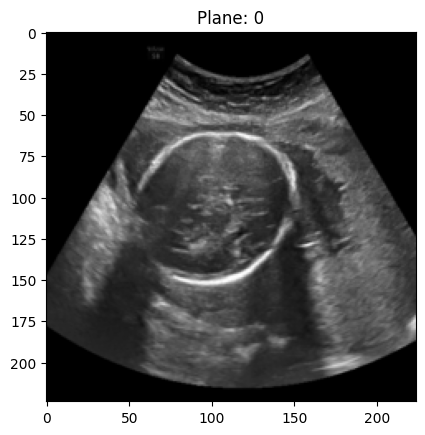

In [23]:
train_dataloader = DataLoader(african_train_dataset, batch_size=24, shuffle="True")
val_dataloader = DataLoader(african_val_dataset, batch_size=24)
ims, planes = next(iter(val_dataloader))

for i, p in list(zip(ims, planes)):
    plt.imshow(i[0], cmap="gray")
    plt.title(f"Plane: {p}")
    plt.show()
    break

In [24]:
afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(afr_model.parameters(), lr=0.001)

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
num_epochs = 3
# num_epochs = 100

# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf_8020.pt'
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt_8020.pt'

model_save_path = DATA_PATH+'/models/afr_clf_8020.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_ckpt_8020.pt'

train_model(train_dataloader,
            val_dataloader,
            afr_model,
            optimizer,
            num_epochs,
            model_save_path,
            checkpoint_save_path,
            device,
            load_checkpoint=True)

/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Epoch 2 iteration 0 training loss: 0.11334007233381271
Epoch 2 iteration 10 training loss: 0.08614194393157959
Epoch 2 average training loss: 0.40874339872971177, average validation loss: 1.0247450694441795
Running time: 21.68219828605652s
Execution time: 21.682241916656494s


## Evaluate

In [26]:
# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf.pt'
model_save_path = DATA_PATH+'/models/afr_clf.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, model=afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")



/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


Loaded model from best epoch 3 with validation loss: 0.21015007589012386


/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


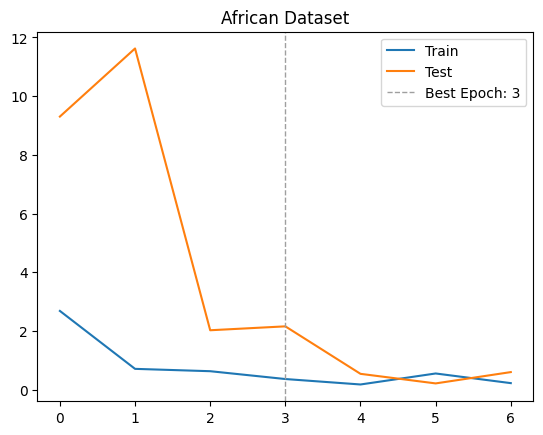

In [29]:
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_ckpt.pt'
_, _, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)


In [30]:
DATABASE_CSV=DATA_PATH+"/African_planes_database.csv"
image_size = 224

transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])
                                                 
african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

val_dataloader = DataLoader(african_val_dataset, batch_size=8)

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))

Accuracy: 0.9484978540772532
Precision: [1.         0.953125   0.96774194 0.8372093 ]
Recall: [0.98461538 0.93846154 0.9375     0.92307692]
F1: [0.99224806 0.94573643 0.95238095 0.87804878]
Support: [65 65 64 39]


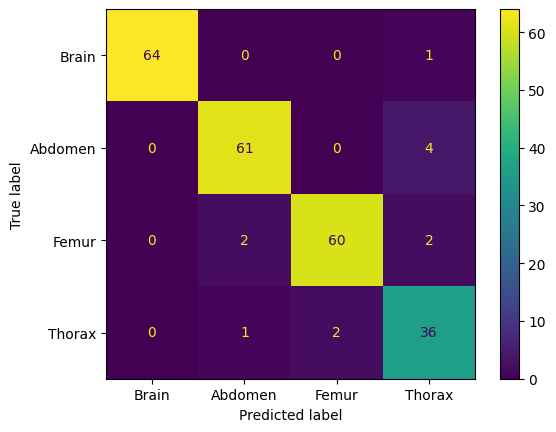

In [31]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

## Evaluate with augmentation

In [32]:
# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_aug_clf.pt'
model_save_path = DATA_PATH+'/models/afr_aug_clf.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See h

Loaded model from best epoch 2 with validation loss: 0.7080864913761615


/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


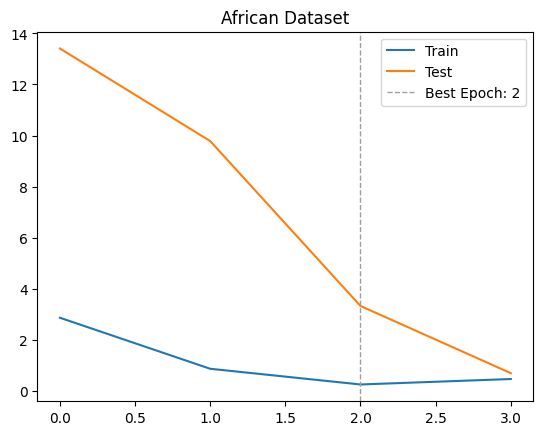

In [33]:
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_aug_ckpt.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_aug_ckpt.pt'
_, _, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

In [34]:
image_size = 224
DATABASE_CSV=DATA_PATH+"/African_planes_database_8020.csv"


transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])



african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))


Accuracy: 0.8240343347639485
Precision: [0.74418605 0.96       1.         0.69090909]
Recall: [0.98461538 0.73846154 0.65625    0.97435897]
F1: [0.84768212 0.83478261 0.79245283 0.80851064]
Support: [65 65 64 39]


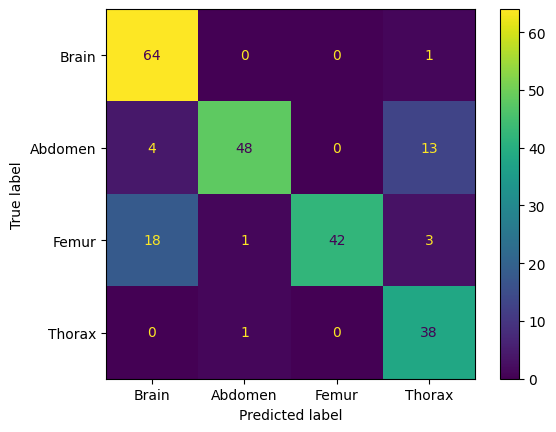

In [35]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)

## Evaluate 80/20

In [41]:
# model_save_path = '/content/drive/MyDrive/xfetus/models/afr_clf_8020.pt'`
model_save_path = DATA_PATH+'/models/afr_clf_8020.pt'

afr_model = models.densenet169(pretrained=True)
num_features = afr_model.classifier.in_features
afr_model.fc = nn.Linear(num_features, 4)
afr_model = afr_model.to(device)

epoch, best_epoch, model, optimizer, train_losses, val_losses = load_model(model_save_path, device, afr_model)
print(f"Loaded model from best epoch {best_epoch} with validation loss: {val_losses[-1]}")

/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mxochicale/repositories/xfetus/xfetus/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See h

Loaded model from best epoch 2 with validation loss: 1.0247450694441795


/tmp/ipykernel_27691/2513486415.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


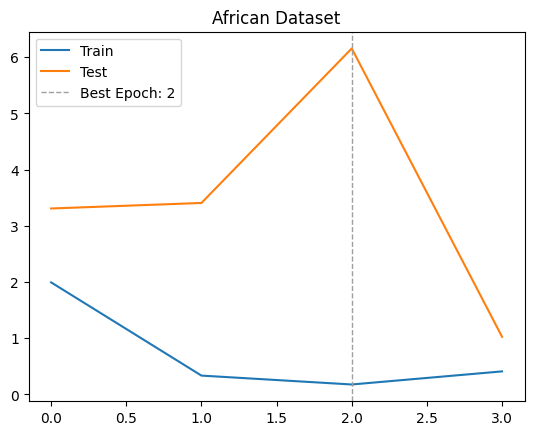

In [42]:
# checkpoint_save_path = '/content/drive/MyDrive/xfetus/checkpoints/afr_ckpt_8020.pt'
checkpoint_save_path = DATA_PATH+'/models/afr_ckpt_8020.pt'
_, _, _, _, full_train_losses, full_val_losses = load_model(checkpoint_save_path, device)
title = "African Dataset"
plot_training_curve(full_train_losses, full_val_losses, best_epoch, title)

In [45]:
# Evaluate with validation from 80/20 split
image_size = 224
DATABASE_CSV=DATA_PATH+"/African_planes_database_8020.csv"


transform_operations=transforms.Compose([
                        #mt.RandRotate(range_x=0.1, prob=0.5),
                        #mt.RandZoom(prob=0.5, min_zoom=1, max_zoom=1.1),
                        #mt.Resize([image_size, image_size]),
                        transforms.Grayscale(num_output_channels=3),#mean=0.5, std=0.5
                        transforms.ToTensor(),
                        transforms.Resize([image_size, image_size], antialias=True),
                        transforms.Normalize((0.5), (0.5)),
                        ])

african_val_dataset = AfricanFetalPlaneDataset(DATA_PATH,
                                           DATABASE_CSV,
                                           transform=transform_operations,
                                           return_labels=True,
                                           split_type="csv",
                                           split="valid")


val_dataloader = DataLoader(african_val_dataset, batch_size=8)

afr_model.eval()
pred_list = []
label_list = []
with torch.no_grad():
  for inputs, labels in val_dataloader:
    # plt.imshow(inputs)
    inputs = inputs.to(device)
    outputs = afr_model(inputs)
    _, preds = torch.max(outputs, 1)
    pred_list = np.concatenate((pred_list, preds.detach().cpu().numpy()))
    label_list = np.concatenate((label_list, labels))


Accuracy: 0.8089887640449438
Precision: [0.68571429 1.         0.80645161 1.        ]
Recall: [0.96       0.72       1.         0.35714286]
F1: [0.8        0.8372093  0.89285714 0.52631579]
Support: [25 25 25 14]


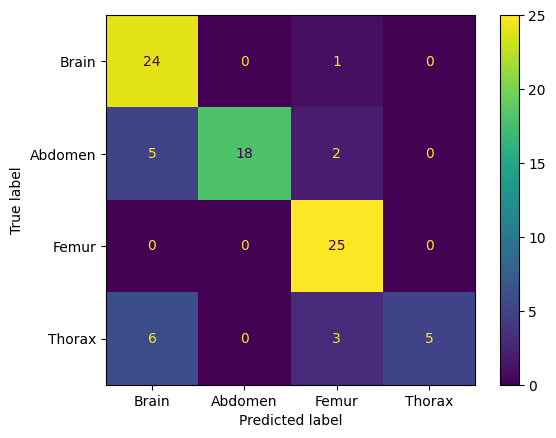

In [46]:
class_names = ["Brain", "Abdomen", "Femur", "Thorax"]
evaluate_model(label_list, pred_list, class_names)